# Introduction to Optimal Transport with Python

#### *Rémi Flamary, Nicolas Courty*

## POT installation

+ Install with pip:
```bash
pip install pot
```
+ Install with conda
```bash
conda install -c conda-forge pot
```

## POT Python Optimal Transport Toolbox

#### Import the toolbox

In [1]:
pip install pot pymanopt autograd matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import scipy as sp
import pylab as pl 

import ot

#### Getting help

Online  documentation : [http://pot.readthedocs.io](http://pot.readthedocs.io) 

Or inline help:


In [2]:
help(ot.dist)

Help on function dist in module ot.utils:

dist(x1, x2=None, metric='sqeuclidean', p=2, w=None)
    Compute distance between samples in :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`
    
    .. note:: This function is backend-compatible and will work on arrays
        from all compatible backends.
    
    Parameters
    ----------
    
    x1 : array-like, shape (n1,d)
        matrix with `n1` samples of size `d`
    x2 : array-like, shape (n2,d), optional
        matrix with `n2` samples of size `d` (if None then :math:`\mathbf{x_2} = \mathbf{x_1}`)
    metric : str | callable, optional
        'sqeuclidean' or 'euclidean' on all backends. On numpy the function also
        accepts  from the scipy.spatial.distance.cdist function : 'braycurtis',
        'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice',
        'euclidean', 'hamming', 'jaccard', 'kulczynski1', 'mahalanobis',
        'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sok

## First OT Problem

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in a City (In this case Manhattan). We did a quick google map search in Manhattan for bakeries and Cafés:

![bak.png](https://remi.flamary.com/cours/otml/bak.png)

We extracted from this search their positions and generated fictional production and sale number (that both sum to the same value).

We have acess to the position of Bakeries ```bakery_pos``` and their respective production ```bakery_prod``` which describe the source distribution. The Cafés where the croissants are sold are defiend also by their position ```cafe_pos``` and ```cafe_prod```. For fun we also provide a map ```Imap``` that will illustrate the position of these shops in the city.


Now we load the data



In [6]:
data=np.load('data/manhattan.npz')

bakery_pos=data['bakery_pos']
bakery_prod=data['bakery_prod']
cafe_pos=data['cafe_pos']
cafe_prod=data['cafe_prod']
Imap=data['Imap']

print('Bakery production: {}'.format(bakery_prod))
print('Cafe sale: {}'.format(cafe_prod))
print('Total croissants : {}'.format(cafe_prod.sum()))

Bakery production: [31. 48. 82. 30. 40. 48. 89. 73.]
Cafe sale: [82. 88. 92. 88. 91.]
Total croissants : 441.0


#### Plotting bakeries in the city

Next we plot the position of the bakeries and cafés on the map. The size of the circle is proportional to their production.


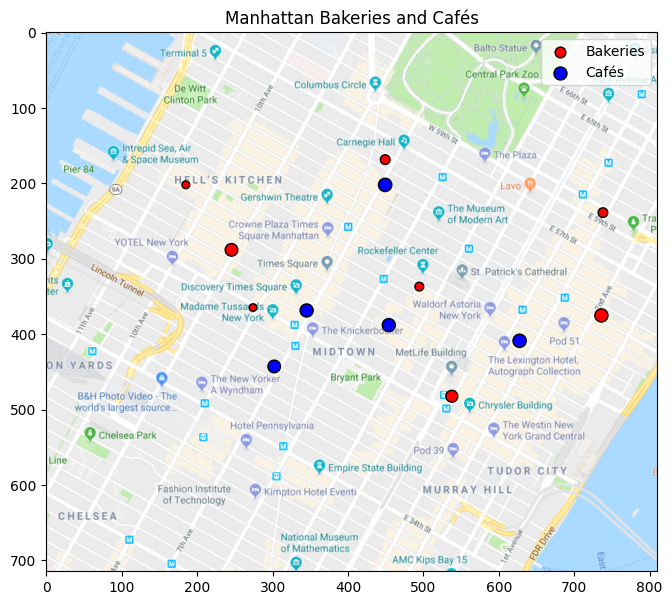

In [7]:

pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
pl.legend()
pl.title('Manhattan Bakeries and Cafés');


#### Cost matrix


We compute the cost matrix between the bakeries and the cafés, this will be the transport cost matrix. This can be done using the [ot.dist](http://pot.readthedocs.io/en/stable/all.html#ot.dist) that defaults to squared euclidean distance but can return other things such as cityblock (or manhattan distance). 



In [39]:
cost_matrix = ot.dist(bakery_pos, cafe_pos, metric='cityblock')
print(cost_matrix)

[[358.1894393  326.95645073 264.4904736  455.35873707 649.69733261]
 [421.64305156 304.34582782  33.6599269  224.28322576 418.62182129]
 [211.33120771 180.09821915 289.98499106 308.50050548 502.83910102]
 [106.2336107   75.00062213 338.00972082 203.40290847 397.741504  ]
 [298.44917956 181.15195583 180.26028463  91.6173886  204.94657438]
 [640.1903725  522.89314877 325.72649506 433.35858154 280.66397076]
 [501.68426783 397.59055914 460.05653628 294.85247686 142.15786609]
 [275.18018508 306.41317365 368.87915079 178.01088732 163.39077689]]


#### Solving the OT problem with [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd)

In [40]:
transport_plan = ot.emd(bakery_prod, cafe_prod, cost_matrix)
print("Optimal Transport Plan (Bakery to Café):")
print(transport_plan)

Optimal Transport Plan (Bakery to Café):
[[31.  0.  0.  0.  0.]
 [ 0.  0. 48.  0.  0.]
 [24. 58.  0.  0.  0.]
 [ 0. 30.  0.  0.  0.]
 [ 0.  0.  0. 40.  0.]
 [ 0.  0. 44.  2.  2.]
 [ 0.  0.  0.  0. 89.]
 [27.  0.  0. 46.  0.]]


#### Transportation plan vizualization

A good vizualization of the OT matrix in the 2D plane is to denote the transportation of mass between a Bakery and a Café by a line. This can easily be done with a double ```for``` loop.

In order to make it more interpretable one can also use the ```alpha``` parameter of plot and set it to ```alpha=G[i,j]/G[i,j].max()```. 

In [41]:
def draw_result(pos1, prod1, pos2, prod2, label1, label2, transport_plan):
    pl.figure(1,(8,7))
    pl.clf()
    pl.imshow(Imap, interpolation='bilinear')
    pl.scatter(pos1[:,0], pos1[:,1], s=prod1, c='r', edgecolors='k', label=label1)
    pl.scatter(pos2[:,0], pos2[:,1], s=prod2, c='b', edgecolors='k', label=label2)

    for i in range(len(pos1)):
        for j in range(len(pos2)):
            G_ij = transport_plan[i, j]

            if G_ij > 0:
                alpha = G_ij / transport_plan.max()
                pl.plot([pos1[i, 0], pos2[j, 0]], 
                        [pos1[i, 1], pos2[j, 1]], 
                         c='green', alpha=alpha, lw=2)

    pl.xlabel('X Coordinate')
    pl.ylabel('Y Coordinate')
    pl.title(f'Optimal Transport Plan: {label1} to {label2}')
    pl.legend(loc='upper right')
    pl.grid(True)
    pl.show()

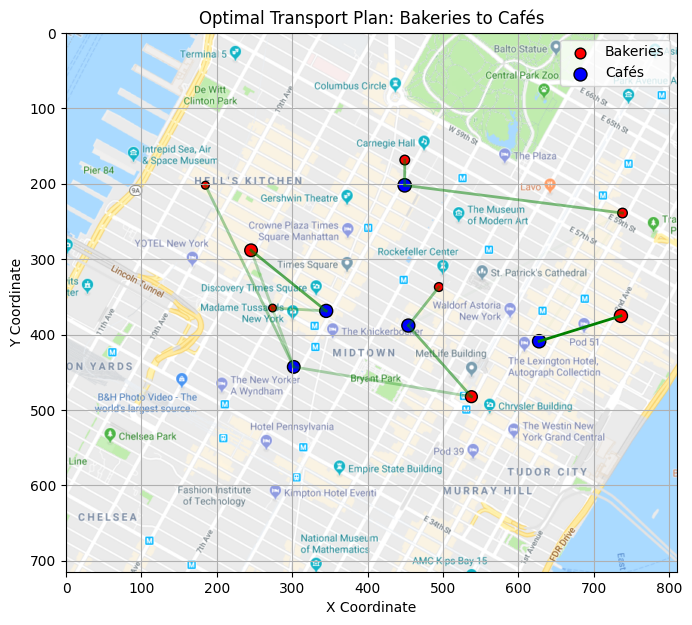

In [42]:
draw_result(bakery_pos, bakery_prod, cafe_pos, cafe_prod, 'Bakeries', 'Cafés', transport_plan)

#### OT loss and dual variables

The resulting wasserstein loss loss is of the form:

$W=\sum_{i,j}\gamma_{i,j}C_{i,j}$

where $\gamma$ is the optimal transport matrix.


In [43]:
total_cost = (transport_plan * cost_matrix).sum()
print("Total Transport Cost: ", total_cost)

Total Transport Cost:  78182.33579594061


#### Regularized OT with SInkhorn

The Sinkhorn algorithm is very simple to code. You can implement it directly using the following pseudo-code:

![sinkhorn.png](http://remi.flamary.com/cours/otml/sink.png)

An alternative is to use the POT toolbox with [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn)

Be carefull to numerical problems. A good pre-provcessing for Sinkhorn is to divide the cost matrix ```C```
 by its maximum value.

In [45]:
def sinkhorn_knopp(a, b, C, lamb, n_iter=100):
    K = np.exp(-C / lamb)
    u = np.ones_like(a)
    for _ in range(n_iter):
        v = b / (K.T @ u)
        u = a / (K @ v)
    T = np.diag(u) @ K @ np.diag(v)
    return T

cost_matrix_new = cost_matrix/cost_matrix.max()
transport_plan = sinkhorn_knopp(bakery_prod, cafe_prod, cost_matrix_new, 0.01, n_iter=100)
print("Transport Plan:")
print(transport_plan)
total_cost = (transport_plan * cost_matrix).sum()
print("Total Transport Cost: ", total_cost)

Transport Plan:
[[1.17650067e+01 1.81620909e+01 1.07290247e+00 2.27446587e-12
  1.59260796e-30]
 [1.12112438e-17 9.80049980e-12 4.80000000e+01 1.05665993e-10
  7.39885806e-29]
 [3.22360211e+01 4.97639789e+01 8.85678126e-12 6.23201769e-12
  4.36373264e-30]
 [1.17936662e+01 1.82063338e+01 1.88373604e-22 2.28000647e-12
  1.59648755e-30]
 [9.66816795e-07 8.45159375e-01 3.82259055e-06 3.91548358e+01
  7.13086926e-12]
 [8.47949208e-13 7.41249248e-07 4.42093919e+01 3.43408515e-05
  3.79057306e+00]
 [1.99090725e-11 2.28059282e-06 6.00182027e-16 8.06291811e-04
  8.89991914e+01]
 [2.52378627e+01 2.60043892e-03 6.84355701e-13 4.77564305e+01
  3.10630655e-03]]
Total Transport Cost:  77749.04655154662


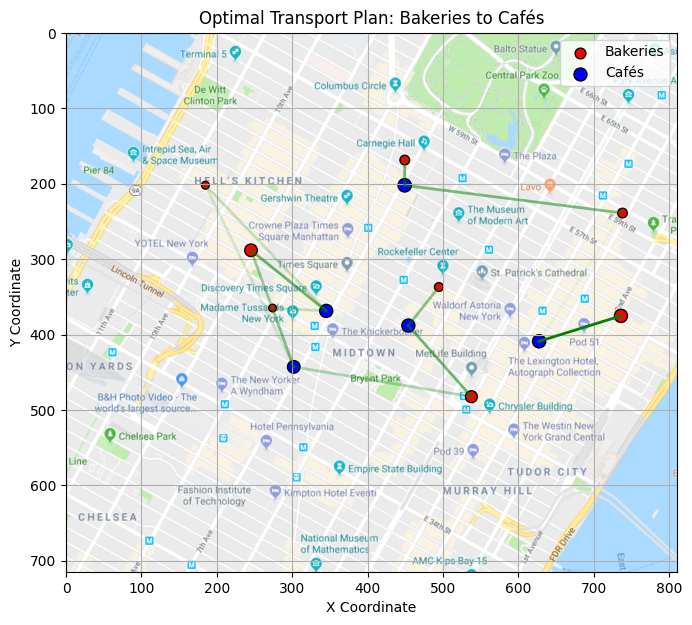

In [46]:
draw_result(bakery_pos, bakery_prod, cafe_pos, cafe_prod, 'Bakeries', 'Cafés', transport_plan)

In [47]:
cost_matrix_new = cost_matrix/cost_matrix.max()
transport_plan = ot.sinkhorn(bakery_prod, cafe_prod, cost_matrix_new, 0.01)
print("Transport Plan:")
print(transport_plan)
total_cost = (transport_plan * cost_matrix).sum()
print("Total Transport Cost: ", total_cost)

Transport Plan:
[[1.21195370e+01 1.88800440e+01 4.19004360e-04 2.22579109e-12
  6.45009183e-34]
 [2.95725890e-14 2.60871769e-08 4.79999997e+01 2.64778010e-07
  7.67296845e-29]
 [3.20585633e+01 4.99414367e+01 3.33920430e-15 5.88765600e-12
  1.70617638e-33]
 [1.17287427e+01 1.82712573e+01 7.10210549e-26 2.15402049e-12
  6.24210872e-34]
 [1.01639410e-06 8.96602350e-01 1.52349200e-09 3.91033966e+01
  2.94729489e-15]
 [2.22609443e-09 1.96372794e-03 4.40000057e+01 8.56438002e-02
  3.91238678e+00]
 [4.95518104e-08 5.72795451e-03 5.66312217e-16 1.90639053e+00
  8.70878815e+01]
 [2.60929267e+01 2.71306492e-03 2.68235687e-16 4.69043590e+01
  1.26263464e-06]]
Total Transport Cost:  78203.84161990897


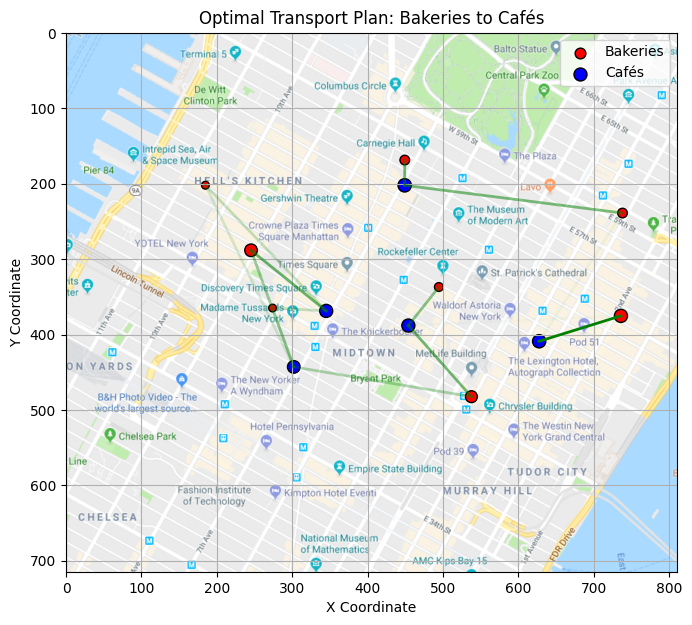

In [48]:
draw_result(bakery_pos, bakery_prod, cafe_pos, cafe_prod, 'Bakeries', 'Cafés', transport_plan)